# <span style="color:orange">3:</span> Part 2 - COVID-19 patient activity in Seoul

__Basic stats and data analysis__

This part presents the basic stats and the data anaysis for the COVID-19 patient activity in Seoul. Three datasets will be analyzed:

* _PatientRoute_ table from the [Data Science for COVID-19 (DS4C)](https://www.kaggle.com/kimjihoo/coronavirusdataset)
* _seoul-maps_ shapefiles from [southkora GitHub repository](https://github.com/southkorea/seoul-maps)
* _buildings_ shapefiles from [OpenStreetMaps data](http://download.geofabrik.de/)


In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shapefile as shp

import ipywidgets as widgets

import datetime

from bokeh.io import push_notebook, curdoc, export_png, save
from bokeh.layouts import widgetbox, row, column
from bokeh.models import Column, ColumnDataSource, Slider, HoverTool, LinearColorMapper, BasicTicker, ColorBar, Dropdown
from bokeh.palettes import brewer
from bokeh.plotting import figure, save, show, output_notebook
output_notebook()


Bad key "text.kerning_factor" on line 4 in
C:\Users\jacqu\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Loading BokehJS ...

## <span style="color:orange">3.1:</span> _PatientRoute_ - Basic stats and data analysis

In [2]:
PatientRoute  = pd.read_csv('./data/PatientRoute.csv')
PatientRoute.head()

patient_id  global_num        date     province          city  \
0  1000000001         2.0  2020-01-22  Gyeonggi-do      Gimpo-si   
1  1000000001         2.0  2020-01-24        Seoul       Jung-gu   
2  1000000002         5.0  2020-01-25        Seoul   Seongbuk-gu   
3  1000000002         5.0  2020-01-26        Seoul   Seongbuk-gu   
4  1000000002         5.0  2020-01-26        Seoul  Seongdong-gu   

                    type   latitude   longitude  
0                airport  37.615246  126.715632  
1               hospital  37.567241  127.005659  
2                    etc  37.592560  127.017048  
3                  store  37.591810  127.016822  
4  public_transportation  37.563992  127.029534

Since this part of the analyses focuse on the city of Seoul, the data is filtered on that attribute (Seoul is officially a "province" in korean administrative terms, but we will here use the term of city).

In [3]:
pdf  = PatientRoute[PatientRoute['province']== 'Seoul'].copy()

Let's look at the different districts of Seoul:

In [4]:
pdf.city.unique()

array(['Jung-gu', 'Seongbuk-gu', 'Seongdong-gu', 'Dongdaemun-gu',
       'Jungnang-gu', 'Gangnam-gu', 'Jongno-gu', 'Songpa-gu',
       'Seodaemun-gu', 'Mapo-gu', 'Eunpyeong-gu', 'Seocho-gu',
       'Gwangjin-gu', 'Guro-gu', 'Dobong-gu', 'Dongjak-gu',
       'Geumcheon-gu', 'Yeongdeungpo-gu', 'Gangdong-gu', 'Nowon-gu',
       'Yangcheon-gu', 'Yongsan-gu', 'Gangseo-gu', 'Gwanak-gu',
       'Gangbuk-gu'], dtype=object)

Seoul is divided into 25 different districts (here again, in official korean administrative terms, city districts are called "cities" and their name ends with "-gu", however we will keep the terms "districts" later on).

When grouping the dataframe by districts and counting the values, we can identify the districts in wich most infected patient activities have been registered.

Text(0, 0.5, 'activity count')

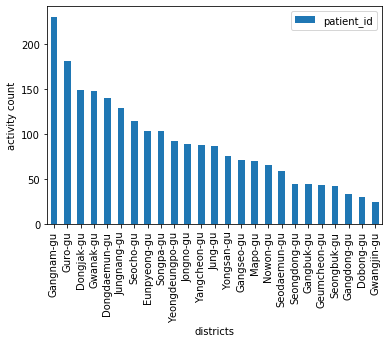

In [5]:
ax = pdf.groupby('city').count().sort_values(by='patient_id', ascending=False)[['patient_id']].plot.bar()
ax.set_xlabel("districts")
ax.set_ylabel("activity count")

Let's try grouping the activities by activity types: 

Text(0, 0.5, 'count')

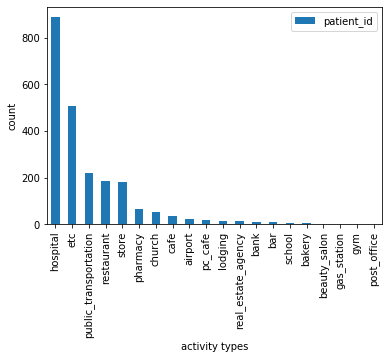

In [6]:
ax = pdf.groupby('type').count().sort_values(by='patient_id', ascending=False)[['patient_id']].plot.bar()
ax.set_xlabel("activity types")
ax.set_ylabel("count")

Some registered activity types are dominant, it has therefore been decided to group the activity types into 5 main types.

In [7]:
types = ['health', 'transport', 'supplies', 'education', 'others']
types_dict = dict(zip(types, [x for x in range(5)]))
print(types_dict)

{'health': 0, 'transport': 1, 'supplies': 2, 'education': 3, 'others': 4}


In [8]:
#Define patient activity groups
p1 = ['hospital', 'pharmacy'] #health
p2 = ['public_transportation', 'airport'] #travel
p3 = ['store', 'bakery'] #supplies
p4 = ['school', 'pc_cafe'] #education
ptypes = [p1, p2, p3, p4, [t for t in pdf.type.unique() if t not in p1+p2+p3+p4]]

#Classify patient activity type
def classify_ptype(x, types, ptypes):
    t = -1
    for i in range(len(types)):
        if x in ptypes[i]:
            t = i
    return t
pdf['ptype'] = pdf['type'].apply(lambda x: classify_ptype(x, types, ptypes))

pdf.head()

patient_id  global_num        date province          city  \
1  1000000001         2.0  2020-01-24    Seoul       Jung-gu   
2  1000000002         5.0  2020-01-25    Seoul   Seongbuk-gu   
3  1000000002         5.0  2020-01-26    Seoul   Seongbuk-gu   
4  1000000002         5.0  2020-01-26    Seoul  Seongdong-gu   
5  1000000002         5.0  2020-01-26    Seoul   Seongbuk-gu   

                    type   latitude   longitude  ptype  
1               hospital  37.567241  127.005659      0  
2                    etc  37.592560  127.017048      4  
3                  store  37.591810  127.016822      2  
4  public_transportation  37.563992  127.029534      1  
5  public_transportation  37.590330  127.015221      1

Let's try having a look at the dates of the registered activities:

In [9]:
print('First registered activity:', pdf.date.min())
print('Last registered activity:', pdf.date.max())

First registered activity: 2020-01-22
Last registered activity: 2020-04-17


Text(0, 0.5, 'count')

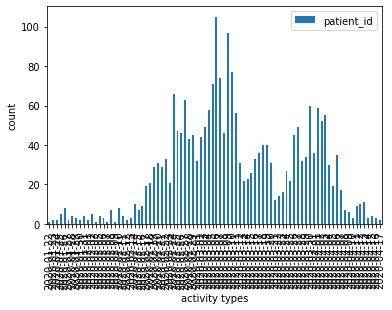

In [10]:
ax = pdf.groupby('date').count()[['patient_id']].plot.bar()
ax.set_xlabel("activity types")
ax.set_ylabel("count")

Let us also create some useful temporal attributes for later.

In [11]:
#Create temporal attributes
pdf['datetime'] = pd.to_datetime(pdf['date'])
pdf['days'] = (pdf.datetime-pdf.datetime.min()).apply(lambda td: td.days) #Days since first case

N = 87 #Number of days
days = [d for d in range(N)]
date_0 = '2020-01-22'
def get_next_date(date): return str(pd.to_datetime(date) + datetime.timedelta(days = 1))[:10]
dates = [date_0]
for d in range(N-1): dates.append(get_next_date(dates[-1]))
days2dates_dict = dict(zip(days, dates))

The _PatientRoute_ also contains geographic coordinates, but it will be more interesting to visualize those using the district shapes of Seoul in the next part. 

## <span style="color:orange">3.2:</span> _seoul-maps data - gdf_

This dataset contains the shapefiles of the districts of Seoul. In order to read the _.shp_ files into a dataframe, we need to define a function:

In [12]:
def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#Read shapes of Seoul districts
gsf = shp.Reader('./data/seoul_municipalities.shp', encoding='gbk')
shapes = read_shapefile(gsf).rename(columns={'ESRI_PK': 'id', 'SIG_ENG_NM' : 'name'})
shapes.head()

SIG_CD SIG_KOR_NM           name  id  SHAPE_AREA  SHAPE_LEN  \
0  11320        档豪备      Dobong-gu   0    0.002110   0.239901   
1  11380        篮乞备   Eunpyeong-gu   1    0.003041   0.327143   
2  11230       悼措巩备  Dongdaemun-gu   2    0.001453   0.182837   
3  11590        悼累备     Dongjak-gu   3    0.001670   0.237796   
4  11545        陛玫备   Geumcheon-gu   4    0.001325   0.211649   

                                              coords  
0  [(127.019851357, 37.700884901999984), (127.022...  
1  [(126.95173726300004, 37.654891147), (126.9518...  
2  [(127.07109525999999, 37.60732730400002), (127...  
3  [(126.954724306, 37.51603819799999), (126.9555...  
4  [(126.879936983, 37.486062359000016), (126.880...

In this dataset, the interesting attributes are _name_ (the name of the district), _id_ of the district and _coords_ (the geographical coordinates delimiting each district). In order to plot the district shapes, the coordinates need to be converted into separate _x_ (longitude) and _y_ (latitude) columns:

In [13]:
shapes['x'] = shapes.coords.apply(lambda L: [l[0] for l in L])
shapes['y'] = shapes.coords.apply(lambda L: [l[1] for l in L])
gdf = shapes[['id', 'name', 'x', 'y']].set_index('id')
gdf.head()

name                                                  x  \
id                                                                     
0       Dobong-gu  [127.019851357, 127.02217147700003, 127.023411...   
1    Eunpyeong-gu  [126.95173726300004, 126.95187890199998, 126.9...   
2   Dongdaemun-gu  [127.07109525999999, 127.071188119, 127.071232...   
3      Dongjak-gu  [126.954724306, 126.95556088000001, 126.955566...   
4    Geumcheon-gu  [126.879936983, 126.88033577600004, 126.880610...   

                                                    y  
id                                                     
0   [37.700884901999984, 37.69960736799999, 37.699...  
1   [37.654891147, 37.654866395, 37.65491785500001...  
2   [37.60732730400002, 37.60669169900001, 37.6064...  
3   [37.51603819799999, 37.51571684800001, 37.5157...  
4   [37.486062359000016, 37.48592397499999, 37.485...

For an unknown reason, the 144 last coordinates of the Gangseo-gu district were errors and needed to be removed for the plots to render correctly later on.

In [14]:
#The Gangseo-gu shape (id 10) needs to be corrected
gdf.loc[10].x = gdf.loc[10].x[:-144].copy()
gdf.loc[10].y = gdf.loc[10].y[:-144].copy()

It is now possible to combine the data of the districts with the patient activity data. This way, we can count the total number of activities registered in each district and associate them with a district shape.

In [15]:
#Count the total activity level
data = PatientRoute[PatientRoute['province']== 'Seoul'].copy()
data.date = pd.to_datetime(data.date).copy()
data = data.groupby('city').count()[['patient_id']].reset_index().rename(columns={'patient_id' : 'total_count'})
gdf = gdf.merge(data, left_on='name', right_on='city')
gdf = gdf.drop(columns=['city'])

gdf.head()

name                                                  x  \
0      Dobong-gu  [127.019851357, 127.02217147700003, 127.023411...   
1   Eunpyeong-gu  [126.95173726300004, 126.95187890199998, 126.9...   
2  Dongdaemun-gu  [127.07109525999999, 127.071188119, 127.071232...   
3     Dongjak-gu  [126.954724306, 126.95556088000001, 126.955566...   
4   Geumcheon-gu  [126.879936983, 126.88033577600004, 126.880610...   

                                                   y  total_count  
0  [37.700884901999984, 37.69960736799999, 37.699...           30  
1  [37.654891147, 37.654866395, 37.65491785500001...          103  
2  [37.60732730400002, 37.60669169900001, 37.6064...          140  
3  [37.51603819799999, 37.51571684800001, 37.5157...          149  
4  [37.486062359000016, 37.48592397499999, 37.485...           43

In order to distinguish between the activity count values, we can define percentiles:

In [16]:
#Compute the total activity percentiles
p     = [10, 20, 40, 50, 60, 80, 90, 100]
p_val = np.percentile(gdf.total_count, p)
gdf['total_count_p'] = gdf.total_count.apply(lambda t: np.searchsorted(p_val, t))

Finally, using color palettes and color mappers in Bokeh, we can plot the total count of patient activity for each district of the city, on an interactive map!

In [17]:
#Set figure parameters
fig_options = {
    'title': 'COVID-19 patients activity in Seoul, all dates',
    'x_range' : (126.755, 127.2),
    'y_range' : (37.42, 37.71), 
    'x_axis_label' : 'Longitude',
    'y_axis_label' : 'Latitude',
    'plot_height' : 650, 
    'plot_width' : 850,
    'toolbar_location' : "above"
}

#Set district parameters
palette = brewer['YlGnBu'][8][::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 8)
geo_parameters = {
    'legend_label' : 'Districts',
    'fill_color' : {'field' :'total_count_p', 'transform' : color_mapper},
    'line_color' : 'black',
    'line_width' : 0.25,
    'fill_alpha' : 0.9
}

#Set colorbar parameters
tick_labels = {'0':'0', '1':'37', '2':'44', '3': '71', '4':'87', '5':'90', '6':'131', '7': '149', '8':'231'}
colorbar_options = {
    'label_standoff' : 8,
    'width' : 20,
    'height' : 567,
    'border_line_color' : None,
    'location' : (0,0),
    'orientation' : 'vertical',
    'major_label_overrides' : tick_labels
}

#Set data
geosource = ColumnDataSource(gdf)

#Create color bar
color_bar = ColorBar(color_mapper=color_mapper, **colorbar_options)

#Create figure
p = figure(**fig_options)

#Plot districts
geo = p.patches('x', 'y', source = geosource, **geo_parameters)

#Add hover tool
hover = HoverTool()
hover.tooltips = [('District', '@name'), ('Activities registered' , '@total_count')]
p.add_tools(hover)
p.add_layout(color_bar, 'right')

#Display in notebook and show
show(p)

This visualization shows us the different districts of Seoul and tells us how much total patient activity is registered in each of them. However, two very interesting attributes from the original _PatientRoute_ table are not used here: _date_ and _type_. The followings steps are therefore to include those.

## <span style="color:orange">3.3:</span> _buildings data - bdf_

In order to get a better sense of the main activity types of each district, we downloaded building shapefiles from OpenStreetMaps and load them into a dataframe. Loading takes some time because of the size of the files.

In [18]:
bsf = shp.Reader('./data/buildings.shp')
df = read_shapefile(bsf)
df.head()

osm_id  code    fclass  name       type  \
0  22493133  1500  building  크랩마트              
1  23996113  1500  building           school   
2  23996114  1500  building           school   
3  23996115  1500  building           school   
4  24060036  1500  building        container   

                                              coords  
0  [(129.0118404, 35.0634508), (129.0120183, 35.0...  
1  [(128.4564528, 37.4977577), (128.4574226, 37.4...  
2  [(128.4575061, 37.4978267), (128.4579262, 37.4...  
3  [(128.4570514, 37.4977202), (128.4573794, 37.4...  
4  [(128.4423853, 37.4937327), (128.4423935, 37.4...

This dataframe contains the OSM buildings of all South Korea (more than 400.000 entries, hence the big size). In order to filter the buildings on the city of Seoul, we calculate the mean geographical coordinates of each shape and check whether they are within the area of Seoul.

In [19]:
#Format longitude and latitude attributes
df['x'] = df.coords.apply(lambda x: np.array(x)[:,0] )
df['y'] = df.coords.apply(lambda x: np.array(x)[:,1] )
df['x_m'] = df.x.apply(lambda x: np.mean(x))
df['y_m'] = df.y.apply(lambda x: np.mean(x))

#Select building whose center is in the area of Seoul
mask1 = (df['x_m'] >= 126.755) & (df['x_m'] <= 127.2)
mask2 = (df['y_m'] >= 37.42) & (df['y_m'] <= 37.71)
bdf = df[mask1 & mask2]
bdf.head()

osm_id  code    fclass       name        type  \
5  26281660  1500  building       롯데월드               
6  26335946  1500  building  동선1동 주민센터               
7  26628700  1500  building      과학도서관               
8  26628701  1500  building    자연계 생활관  university   
9  26628702  1500  building      아산이학관  university   

                                              coords  \
5  [(127.0958781, 37.5117032), (127.0987936, 37.5...   
6  [(127.0203309, 37.5939179), (127.020343, 37.59...   
7  [(127.0258941, 37.5844145), (127.0270097, 37.5...   
8  [(127.0271195, 37.5844104), (127.0271412, 37.5...   
9  [(127.0247042, 37.5852243), (127.0248827, 37.5...   

                                                   x  \
5  [127.0958781, 127.0987936, 127.0990155, 127.09...   
6  [127.0203309, 127.020343, 127.0205413, 127.020...   
7  [127.0258941, 127.0270097, 127.0272402, 127.02...   
8  [127.0271195, 127.0271412, 127.0271822, 127.02...   
9  [127.0247042, 127.0248827, 127.0250665, 127.02...   

                                                   y         x_m        y_m  
5  [37.5117032, 37.5124221, 37.5119213, 37.511744...  127.099154  37.510837  
6  [37.5939179, 37.5940669, 37.5940568, 37.593907...  127.020415  37.593973  
7  [37.5844145, 37.5849556, 37.5846572, 37.584548...  127.026543  37.584500  
8  [37.5844104, 37.5844778, 37.5845309, 37.584573...  127.027388  37.584398  
9  [37.5852243, 37.5853082, 37.5850651, 37.585127...  127.025183  37.585260

Let's look at the different building types:

In [20]:
print("Total building types:", len(bdf.type.unique()))

Total building types: 83


Since there are many building types, we hand-pick the most promising ones and classify them into 5 main types, similar to the patient activity types.

In [21]:
#Define building types
g1 = ['hospital', 'medical'] #health
g2 = ['train_station', 'station', 'transportation'] #travel
g3 = ['retail', 'service',  'supermarket'] #Supply
g4 = ['university', 'school', 'kindergarten', 'college',  'library', 'academy'] #education
g5 = ['hotel', 'church', 'museum', 'cathedral', 'temple',  'chapel', 'restaurant', 'police station'] #others
btypes = [g1, g2, g3, g4, g5]

#Select the buildings types defined
mask3 = pd.Series(len(df)*[False])
for g in btypes:
    for a in g: mask3 = mask3 | (df['type'] == a)

#Classify buildings
def classify_btype(x, types, btypes):
    t = -1
    for i in range(len(types)):
        if x in btypes[i]:
            t = i
    return t


bdf = df[mask1 & mask2 & mask3].reset_index()[['type', 'x', 'y']]
bdf['btype'] = bdf['type'].apply(lambda x: classify_btype(x, types, btypes))
bdf

type                                                  x  \
0     university  [127.0271195, 127.0271412, 127.0271822, 127.02...   
1     university  [127.0247042, 127.0248827, 127.0250665, 127.02...   
2     university  [127.0239256, 127.0241266, 127.0242154, 127.02...   
3     university  [127.024073, 127.0243396, 127.0247626, 127.024...   
4     university  [127.0247859, 127.025182, 127.0249187, 127.025...   
...          ...                                                ...   
4922      school  [127.1289571, 127.1291373, 127.1293376, 127.12...   
4923      school  [127.1292367, 127.1293936, 127.1294154, 127.12...   
4924      school  [127.1295314, 127.1296518, 127.1298549, 127.12...   
4925      church  [127.0655596, 127.0657841, 127.0659028, 127.06...   
4926      church  [127.0663946, 127.0664645, 127.0664529, 127.06...   

                                                      y  btype  
0     [37.5844104, 37.5844778, 37.5845309, 37.584573...      3  
1     [37.5852243, 37.5853082, 37.5850651, 37.585127...      3  
2     [37.5848828, 37.5849773, 37.5848588, 37.585044...      3  
3     [37.5843739, 37.5844914, 37.5838888, 37.583771...      3  
4     [37.583423, 37.5836035, 37.5839663, 37.5840675...      3  
...                                                 ...    ...  
4922  [37.5286623, 37.5289909, 37.5289286, 37.528586...      3  
4923  [37.5290563, 37.5293928, 37.5293864, 37.529424...      3  
4924  [37.5289209, 37.5290703, 37.5290251, 37.528865...      3  
4925  [37.5023698, 37.5024487, 37.5022362, 37.502148...      4  
4926  [37.5004076, 37.5004298, 37.5004527, 37.500514...      4  

[4927 rows x 4 columns]

We are now ready to plot buildings of Seoul by building type.

In [22]:
#Set figure parameters
fig_options = {
    'title': 'Different building types in Seoul',
    'x_range' : (126.755, 127.2),
    'y_range' : (37.42, 37.71), 
    'x_axis_label' : 'Longitude',
    'y_axis_label' : 'Latitude',
    'plot_height' : 650, 
    'plot_width' : 800,
    'toolbar_location' : "above"
}

#Set district parameters
geo_parameters = {
    'legend_label' : 'Districts',
    'fill_color' : '#ffffd9',
    'line_color' : 'black',
    'line_width' : 0.25,
    'fill_alpha' : 0.5
}


#Set building parameters
bld_parameters1 = {
    'legend_label' : 'Health',
    'fill_color' : '#db5f57',
    'line_color' : '#db5f57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters2 = {
    'legend_label' : 'Travel',
    'fill_color' : '#b9db57',
    'line_color' : '#b9db57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters3 = {
    'legend_label' : 'Supply',
    'fill_color' : '#57db94',
    'line_color' : '#57db94',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters4 = {
    'legend_label' : 'Education',
    'fill_color' : '#5784db',
    'line_color' : '#5784db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters5 = {
    'legend_label' : 'Others',
    'fill_color' : '#c957db',
    'line_color' : '#c957db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}


#Set colorbar parameters
tick_labels = dict(zip([str(x) for x in range(9)], ['0']+[str(int(x)) for x in p_val]))
colorbar_options = {
    'label_standoff' : 8,
    'width' : 20,
    'height' : 567,
    'border_line_color' : None,
    'location' : (0,0),
    'orientation' : 'vertical',
    'major_label_overrides' : tick_labels
}

p = figure(**fig_options)

#Select initial data
gcols = ['name', 'x', 'y']
# pcols = ['patient_id', 'city', 'ptype', 'type', 'latitude', 'longitude', 'days']
bcols = ['btype', 'x', 'y']
geosource = ColumnDataSource(gdf[gcols])
# patsource = ColumnDataSource(pdf[pcols])
bldsource1 = ColumnDataSource(bdf[bdf['btype'] == 0][bcols])
bldsource2 = ColumnDataSource(bdf[bdf['btype'] == 1][bcols])
bldsource3 = ColumnDataSource(bdf[bdf['btype'] == 2][bcols])
bldsource4 = ColumnDataSource(bdf[bdf['btype'] == 3][bcols])
bldsource5 = ColumnDataSource(bdf[bdf['btype'] == 4][bcols])

#Plot
geo = p.patches('x', 'y', source = geosource, **geo_parameters)
bld1 = p.patches('x', 'y', source = bldsource1, **bld_parameters1)
bld2 = p.patches('x', 'y', source = bldsource2, **bld_parameters2)
bld3 = p.patches('x', 'y', source = bldsource3, **bld_parameters3)
bld4 = p.patches('x', 'y', source = bldsource4, **bld_parameters4)
bld5 = p.patches('x', 'y', source = bldsource5, **bld_parameters5)

# pat = p.circle(x='longitude', y='latitude',  source=patsource, **pat_parameters)
# color_bar = ColorBar(color_mapper=color_mapper, **colorbar_options)

#Add tools
hover = HoverTool()
hover.tooltips = [('District', '@name'), ('(lng, lat)' , '($x, $y)')]
p.add_tools(hover)
# p.add_layout(color_bar, 'right')

#Make legend interactive
p.legend.click_policy = 'hide'

# #Show plot
show(p)

We now can get a great sense of different building types can be found in each district of the city. What is left now is to combine all datasets. 

## Combining the three datasets

For combine all the data, we implemented an interactive map with three main layers:
1. __Districts colored by number of patient activities registered__
2. __Buildings colored by building type__
3. __Precise patient activity locations represented by red dots__

In order to use the _date_ attibute in the visualization, we need to create column for counting the activity by district for each day.

In [23]:
#Count the number of patient movements per day for each district
data = PatientRoute[PatientRoute['province'] == 'Seoul']
data = data.groupby(['city', 'date']).count()[['patient_id']].unstack().fillna(0)
data.columns = data.columns.droplevel(0)
data = data.reset_index()
gdf = gdf.merge(data, left_on='name', right_on='city').drop(columns=['city'])
gdf['2020-02-04'] = np.zeros(len(gdf)) #Add missing date (no movement recorded)
gdf = gdf.rename(columns=dict(zip(dates, ['mov_%d' %(d) for d in range(N)])))
gdf['mov'] = gdf.mov_0.copy()
gdf.head()

name                                                  x  \
0      Dobong-gu  [127.019851357, 127.02217147700003, 127.023411...   
1   Eunpyeong-gu  [126.95173726300004, 126.95187890199998, 126.9...   
2  Dongdaemun-gu  [127.07109525999999, 127.071188119, 127.071232...   
3     Dongjak-gu  [126.954724306, 126.95556088000001, 126.955566...   
4   Geumcheon-gu  [126.879936983, 126.88033577600004, 126.880610...   

                                                   y  total_count  \
0  [37.700884901999984, 37.69960736799999, 37.699...           30   
1  [37.654891147, 37.654866395, 37.65491785500001...          103   
2  [37.60732730400002, 37.60669169900001, 37.6064...          140   
3  [37.51603819799999, 37.51571684800001, 37.5157...          149   
4  [37.486062359000016, 37.48592397499999, 37.485...           43   

   total_count_p  mov_0  mov_1  mov_2  mov_3  mov_4  ...  mov_79  mov_80  \
0              0    0.0    0.0    0.0    0.0    0.0  ...     0.0     0.0   
1              5    0.0    0.0    0.0    0.0    0.0  ...     2.0     0.0   
2              6    0.0    0.0    0.0    0.0    0.0  ...     0.0     0.0   
3              7    0.0    0.0    0.0    0.0    0.0  ...     0.0     7.0   
4              1    0.0    0.0    0.0    0.0    0.0  ...     0.0     0.0   

   mov_81  mov_82  mov_83  mov_84  mov_85  mov_86  mov_13  mov  
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  
1     2.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  
3     5.0     3.0     2.0     1.0     0.0     0.0     0.0  0.0  
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  

[5 rows x 93 columns]

Similarly to what we did for the _total_count_ of activities, we can compute percentiles for the daily counts so as to assign colors to districts.

In [24]:
#Get the max number of movements within a district for each day
mmov = PatientRoute[PatientRoute['province'] == 'Seoul']
mmov = mmov.groupby(['city', 'date']).count()[['patient_id']].unstack().fillna(0).max(axis=0)

#Compute percentiles of mmov for each day and district
p     = [10, 20, 40, 50, 60, 80, 90, 100]
p_val = np.percentile(mmov, p)
for d in days:
    gdf['p_mov_%d' %(d)] = gdf['mov_%d' %(d)].apply(lambda x: np.searchsorted(p_val, x))
gdf['p_mov'] = gdf.p_mov_0.copy()

gdf.head()

name                                                  x  \
0      Dobong-gu  [127.019851357, 127.02217147700003, 127.023411...   
1   Eunpyeong-gu  [126.95173726300004, 126.95187890199998, 126.9...   
2  Dongdaemun-gu  [127.07109525999999, 127.071188119, 127.071232...   
3     Dongjak-gu  [126.954724306, 126.95556088000001, 126.955566...   
4   Geumcheon-gu  [126.879936983, 126.88033577600004, 126.880610...   

                                                   y  total_count  \
0  [37.700884901999984, 37.69960736799999, 37.699...           30   
1  [37.654891147, 37.654866395, 37.65491785500001...          103   
2  [37.60732730400002, 37.60669169900001, 37.6064...          140   
3  [37.51603819799999, 37.51571684800001, 37.5157...          149   
4  [37.486062359000016, 37.48592397499999, 37.485...           43   

   total_count_p  mov_0  mov_1  mov_2  mov_3  mov_4  ...  p_mov_78  p_mov_79  \
0              0    0.0    0.0    0.0    0.0    0.0  ...         0         0   
1              5    0.0    0.0    0.0    0.0    0.0  ...         0         1   
2              6    0.0    0.0    0.0    0.0    0.0  ...         0         0   
3              7    0.0    0.0    0.0    0.0    0.0  ...         1         0   
4              1    0.0    0.0    0.0    0.0    0.0  ...         0         0   

   p_mov_80  p_mov_81  p_mov_82  p_mov_83  p_mov_84  p_mov_85  p_mov_86  p_mov  
0         0         0         0         0         0         0         0      0  
1         0         1         0         0         0         0         0      0  
2         0         0         0         0         0         0         0      0  
3         5         3         2         1         0         0         0      0  
4         0         0         0         0         0         0         0      0  

[5 rows x 181 columns]

Finally, we are able to plot the three layer in a single graph, and include a slider widget in order to select the date column to be displayed.

In [25]:
#Set figure parameters
fig_options = {
    'title': 'COVID-19 patients activity in Seoul',
    'x_range' : (126.755, 127.2),
    'y_range' : (37.42, 37.71), 
    'x_axis_label' : 'Longitude',
    'y_axis_label' : 'Latitude',
    'plot_height' : 650, 
    'plot_width' : 850,
    'toolbar_location' : "above"
}

#Set district parameters
palette = brewer['YlGnBu'][8][::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 8)
geo_parameters = {
    'legend_label' : 'Districts',
    'fill_color' : {'field' :'p_mov', 'transform' : color_mapper},
    'line_color' : 'black',
    'line_width' : 0.25,
    'fill_alpha' : 0.5
}

#Set patient parameters
pat_parameters = {
    'legend_label' : 'Patients',
    'size' : 5, 
    'color' : 'red', 
    'line_color' : None, 
    'fill_alpha' : 1
}

#Set building parameters
bld_parameters1 = {
    'legend_label' : 'Hospitals',
    'fill_color' : '#db5f57',
    'line_color' : '#db5f57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters2 = {
    'legend_label' : 'Travel',
    'fill_color' : '#b9db57',
    'line_color' : '#b9db57',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters3 = {
    'legend_label' : 'Supply',
    'fill_color' : '#57db94',
    'line_color' : '#57db94',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters4 = {
    'legend_label' : 'Education',
    'fill_color' : '#5784db',
    'line_color' : '#5784db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

bld_parameters5 = {
    'legend_label' : 'Others',
    'fill_color' : '#c957db',
    'line_color' : '#c957db',
    'line_width' : 0.1,
    'fill_alpha' : 1.0
}

#Set colorbar parameters
tick_labels = dict(zip([str(x) for x in range(9)], ['0']+[str(int(x)) for x in p_val]))
colorbar_options = {
    'label_standoff' : 8,
    'width' : 20,
    'height' : 567,
    'border_line_color' : None,
    'location' : (0,0),
    'orientation' : 'vertical',
    'major_label_overrides' : tick_labels
}

p = figure(**fig_options)

#Select initial data
gcols = ['name', 'x', 'y', 'mov', 'p_mov']
pcols = ['patient_id', 'city', 'ptype', 'type', 'latitude', 'longitude', 'days']
bcols = ['btype', 'x', 'y']
geosource = ColumnDataSource(gdf[gcols])
patsource = ColumnDataSource(pdf[pcols])
bldsource1 = ColumnDataSource(bdf[bdf['btype'] == 0][bcols])
bldsource2 = ColumnDataSource(bdf[bdf['btype'] == 1][bcols])
bldsource3 = ColumnDataSource(bdf[bdf['btype'] == 2][bcols])
bldsource4 = ColumnDataSource(bdf[bdf['btype'] == 3][bcols])
bldsource5 = ColumnDataSource(bdf[bdf['btype'] == 4][bcols])

#Plot
geo = p.patches('x', 'y', source = geosource, **geo_parameters)
bld1 = p.patches('x', 'y', source = bldsource1, **bld_parameters1)
bld2 = p.patches('x', 'y', source = bldsource2, **bld_parameters2)
bld3 = p.patches('x', 'y', source = bldsource3, **bld_parameters3)
bld4 = p.patches('x', 'y', source = bldsource4, **bld_parameters4)
bld5 = p.patches('x', 'y', source = bldsource5, **bld_parameters5)

pat = p.circle(x='longitude', y='latitude',  source=patsource, **pat_parameters)
color_bar = ColorBar(color_mapper=color_mapper, **colorbar_options)

#Add tools
hover = HoverTool()
hover.tooltips = [('(lng, lat)' , '($x, $y)'), ('Patient activity' , '@type')]
p.add_tools(hover)
p.add_layout(color_bar, 'right')

#Make legend interactive
p.legend.click_policy = 'hide'

#Create updating function
def update(day=0):
    p.title.text = fig_options['title'] + ', ' + days2dates_dict[day]
    
    #Update district data
    for col in ['mov', 'p_mov']:  
        geo.data_source.data[col] = gdf[col + '_' + str(day)]
        
    #Update patient data
    for col in ['latitude', 'longitude']: 
        pat.data_source.data[col] = pdf[pdf['days'] == day][col].copy()
        
    push_notebook()

# #Show plot
show(p, notebook_handle=True)
# show(p)

#Activate and display widgets
day = widgets.IntSlider(min=0, max=86, step=1, value=0, style={'description_width': 'initial'} )

# top_box = widgets.HBox([widgets.Label('Days since 22nd of February: '), day])
ui = widgets.HBox([widgets.Label('Days since 22nd of February: '), day], layout=widgets.Layout(display='flex',flex_flow='column', border='solid 2px',align_items='stretch', width='50%'))

out = widgets.interactive_output(update, {'day' : day})
display(ui, out)

Output()

In case the final plot doesn't render correctly, an animation has been recorded:
<img src="images/gif2.gif">